# Predicting Airbnb House Price in Log Angeles

This notebook focuses on descriptive and exploratory analysis of the data. 


In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import collections
import itertools

import scipy.stats as stats
from scipy.stats import norm
from scipy.special import boxcox1p

import statsmodels
import statsmodels.api as sm

from sklearn.preprocessing import scale, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet,  HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.utils import resample

from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 0. Data Loading and Description

The version of the dataset used throughout this project was reported as of Jun 6, 2022. It contains 42,041 records and 18 variables. The latest version of the house price data in LA is available from the Inside Airbnb [website](http://insideairbnb.com/los-angeles/). 

Data Description:

* id: listing ID
* name: name of the listing
* hist id: host ID
* host_name: name of the host
* neighbourhood_group: location
* neighbourhood: area
* latitude: latitude coordinates
* longitude: longitude coordinates
* room_type: listing space type
* price: price in dollars
* minimum_nights: amount of nights minimum
* number_of_reviews: number of reviews
* last_review: latest review
* reviews_per_month: number of reviews per month
* calculated_host_listings_count: amount of listing per host
* availability_365: number of days when listing is available for booking


In [3]:
Combined_data = pd.read_csv('./drive/MyDrive/Colab Notebooks/kaggle/airbnb/LosAngeles_2022.csv')
Combined_data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,109,Amazing bright elegant condo park front *UPGRA...,521,Paolo,Other Cities,Culver City,33.98301,-118.38607,Entire home/apt,115,30,2,2016-05-15,0.02,1,43,0,NaN
1,2708,Runyon Canyon | Beau Furn Mirror Mini-Suite Fi...,3008,Chas.,City of Los Angeles,Hollywood,34.09625,-118.34605,Private room,93,30,37,2022-03-19,0.38,1,230,8,NaN
2,45392,Cute Home in Mount Washington,201514,Olivia & Alexey,City of Los Angeles,Mount Washington,34.10632,-118.22361,Private room,60,30,27,2022-03-31,0.20,1,329,4,NaN
3,2732,Zen Life at the Beach,3041,Yoga Priestess,Other Cities,Santa Monica,34.00440,-118.48095,Private room,179,7,23,2022-04-08,0.17,2,329,2,228269
4,45417,Silver Lake Cottage Oasis- Private Terrace- Th...,50231247,Tim,City of Los Angeles,Silver Lake,34.09574,-118.27788,Entire home/apt,135,30,154,2022-05-08,1.09,4,131,3,NaN


In [4]:
Combined_data.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,4.204100e+04,4.204100e+04,42041.000000,42041.000000,42041.000000,42041.000000,42041.000000,32413.000000,42041.000000,42041.000000,42041.000000
mean,9.585368e+16,1.398236e+08,33.993940,-118.244240,304.884589,18.117671,35.962299,1.550205,18.758521,179.897029,9.816584
std,2.193591e+17,1.391912e+08,0.188604,0.232477,877.976512,31.585422,72.663178,1.838459,65.693161,135.979395,19.302514
min,1.090000e+02,5.210000e+02,33.338480,-118.961880,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000,0.000000
25%,2.206359e+07,2.225491e+07,33.912290,-118.397160,90.000000,2.000000,1.000000,0.260000,1.000000,45.000000,0.000000
50%,4.192975e+07,8.973744e+07,34.044650,-118.315370,152.000000,10.000000,7.000000,0.860000,2.000000,172.000000,1.000000
75%,5.245321e+07,2.300167e+08,34.100190,-118.105530,288.000000,30.000000,36.000000,2.300000,8.000000,317.000000,10.000000
max,6.422177e+17,4.627862e+08,34.822060,-117.627790,100000.000000,1124.000000,1512.000000,55.790000,532.000000,365.000000,918.000000


In [5]:
print('Number of features: {}'.format(Combined_data.shape[1]))
print('Number of examples: {}'.format(Combined_data.shape[0]))
Combined_data.info()

Number of features: 18
Number of examples: 42041
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42041 entries, 0 to 42040
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              42041 non-null  int64  
 1   name                            42039 non-null  object 
 2   host_id                         42041 non-null  int64  
 3   host_name                       41858 non-null  object 
 4   neighbourhood_group             35328 non-null  object 
 5   neighbourhood                   42041 non-null  object 
 6   latitude                        42041 non-null  float64
 7   longitude                       42041 non-null  float64
 8   room_type                       42041 non-null  object 
 9   price                           42041 non-null  int64  
 10  minimum_nights                  42041 non-null  int64  
 11  number_of_reviews               42041 non-nu

In [6]:
Combined_data['last_review'] = pd.to_datetime(Combined_data['last_review'], infer_datetime_format=True) 

## 1. Preprocessing and EDA


### 1.0 Missing data

After calculating the percentage of missingness for each variable, We notice that there are six variables with NA values. license, name, host_name carry minimal information, so it's safe to remove them from the data. We deal with the remaining three variables one by one.

In [7]:
total = Combined_data.isnull().sum().sort_values(ascending=False)
percent = (Combined_data.isnull().sum())/Combined_data.isnull().count().sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total','Percent'], sort=False).sort_values('Total', ascending=False)
missing_data.head(40)

,Total,Percent
license,31037,0.738256
last_review,9628,0.229015
reviews_per_month,9628,0.229015
neighbourhood_group,6713,0.159677
host_name,183,0.004353
name,2,0.000048
room_type,0,0.000000
host_id,0,0.000000
neighbourhood,0,0.000000
latitude,0,0.000000


In [8]:
Combined_data.drop(['host_name','name', 'license', 'number_of_reviews_ltm'], axis=1, inplace=True)

In [9]:
Combined_data[Combined_data['number_of_reviews'] == 0.0].shape

(9628, 14)

The NaN values in the last_review and reviews_per_month columns mean no reviews were given in the first place. For reviews_per_month, we fill NAs with 0's. For last_review, we fill NAs with the earliest date.

In [10]:
Combined_data['reviews_per_month'] = Combined_data['reviews_per_month'].fillna(0)

In [11]:
earliest = min(Combined_data['last_review'])
Combined_data['last_review'] = Combined_data['last_review'].fillna(earliest)
Combined_data['last_review'] = Combined_data['last_review'].apply(lambda x: x.toordinal() - earliest.toordinal())

In [12]:
Combined_data['last_review']

0        1821
1        3955
2        3967
3        3975
4        4005
         ... 
42036       0
42037       0
42038       0
42039       0
42040       0
Name: last_review, Length: 42041, dtype: int64

Notice that neighbourhood_group has about 15% missing value while neighborhood variable has 0 NA. neighborhood_group can be filled in by neighborhood, if neighborhood of those missing records falls in any group in neighborhood_group. Unfortunately this is not true, it seems that the neighborhood cities cannot be categorized in any neighborhood_group. Therefore, we create a new level of neighborhood_group called 'unknown' and fill in those NAs.

In [13]:
Combined_data['neighbourhood_group'].value_counts()

City of Los Angeles     18386
Other Cities            13671
Unincorporated Areas     3271
Name: neighbourhood_group, dtype: int64

In [14]:
city_of_losangeles = Combined_data[Combined_data['neighbourhood_group'] == 'City of Los Angeles']['neighbourhood'].unique()
other_cities = Combined_data[Combined_data['neighbourhood_group'] == 'Other Cities']['neighbourhood'].unique()
unincorporated_areas = Combined_data[Combined_data['neighbourhood_group'] == 'Unincorporated Areas']['neighbourhood'].unique()

all_cities = list(city_of_losangeles) + list(other_cities) + list(unincorporated_areas)
missing_group_cities = Combined_data[(Combined_data['neighbourhood_group']).isnull()]['neighbourhood'].unique()

num_in = [(i in all_cities) for i in missing_group_cities]
sum(num_in*1)


0

In [15]:
Combined_data['neighbourhood_group'] = Combined_data['neighbourhood_group'].fillna('unknown')

In [16]:
total = Combined_data.isnull().sum().sort_values(ascending=False)
percent = (Combined_data.isnull().sum())/Combined_data.isnull().count().sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total','Percent'], sort=False).sort_values('Total', ascending=False)
missing_data.head(40)

,Total,Percent
id,0,0.0
host_id,0,0.0
neighbourhood_group,0,0.0
neighbourhood,0,0.0
latitude,0,0.0
longitude,0,0.0
room_type,0,0.0
price,0,0.0
minimum_nights,0,0.0
number_of_reviews,0,0.0


### 1.1 Price distribution

I notice that the target has a highly skewed distribution. Skewed outcome makes it harder to make accurate prediction of price or interpret feature importance. A log transformation (log(1+x)) and removal of outliers makes the distribution look much closer to normal.

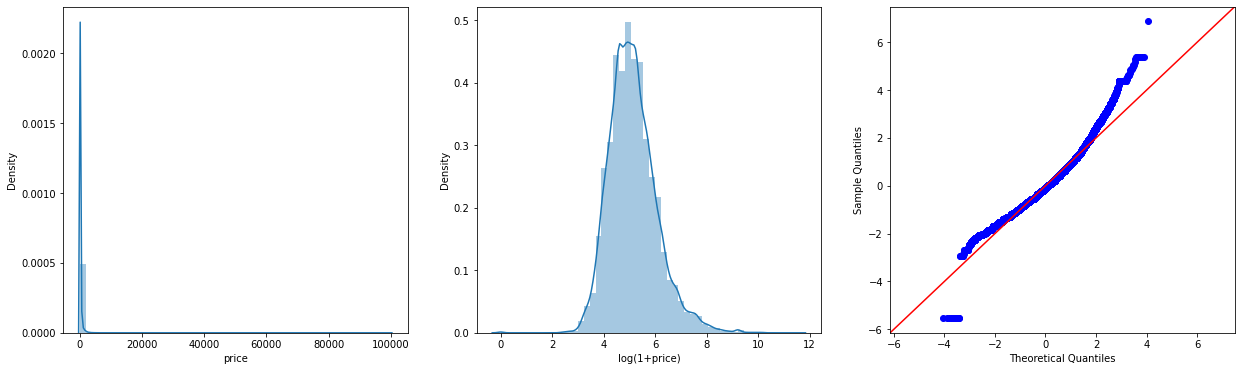

In [17]:
fig, axes = plt.subplots(1,3, figsize=(21,6))
sns.distplot(Combined_data['price'], ax=axes[0])
sns.distplot(np.log1p(Combined_data['price']), ax=axes[1])
axes[1].set_xlabel('log(1+price)')
sm.qqplot(np.log1p(Combined_data['price']), stats.norm, fit=True, line='45', ax=axes[2]);

In [18]:
Combined_data = Combined_data[np.log1p(Combined_data['price']) < 8]
Combined_data = Combined_data[np.log1p(Combined_data['price']) > 3]

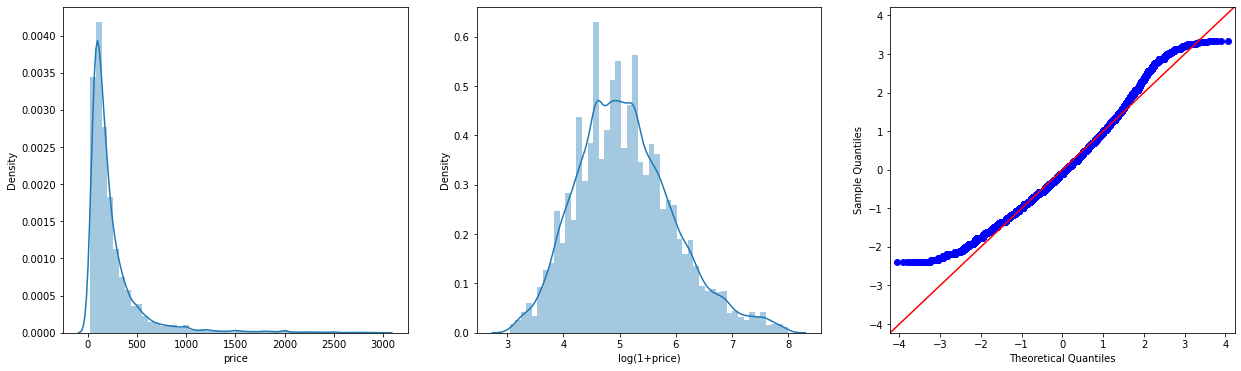

In [19]:
fig, axes = plt.subplots(1,3, figsize=(21,6))
sns.distplot(Combined_data['price'], ax=axes[0])
sns.distplot(np.log1p(Combined_data['price']), ax=axes[1])
axes[1].set_xlabel('log(1+price)')
sm.qqplot(np.log1p(Combined_data['price']), stats.norm, fit=True, line='45', ax=axes[2]);

In [20]:
Combined_data['price'] = np.log1p(Combined_data['price'])

### 1.2 Predictor distributions

In [21]:
Combined_data.columns

Index(['id', 'host_id', 'neighbourhood_group', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')

Host_id

In [22]:
print('There are {} unique hosts renting out a total number of {} properties.'.format(len(Combined_data['host_id'].unique()), Combined_data.shape[0]))

There are 21918 unique hosts renting out a total number of 41597 properties.


In [23]:
Combined_data = Combined_data.drop(['host_id', 'id'], axis=1)

Neighbourhood group

From the bar plot below, we notice that categories of neighbourhood group are imbalanced. A majority of houses locate in the city of Los Angeles because it has the majority of the population.

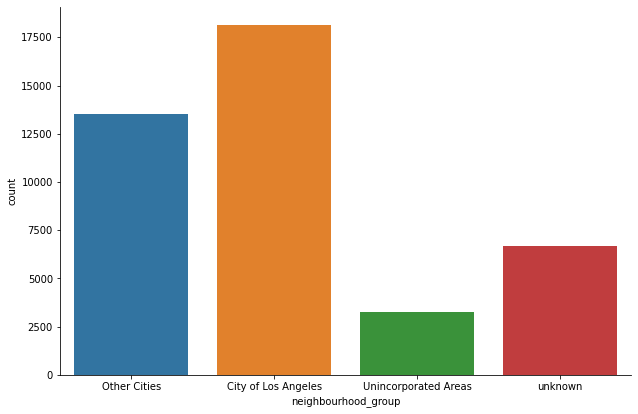

In [24]:
sns.catplot(x='neighbourhood_group', kind='count' ,data=Combined_data)
fig = plt.gcf()
fig.set_size_inches(10, 6)

Longitude and latitude

Longitude and latitude are sort of correlated with each other. This is because the locations of properties tend to come from clusters.

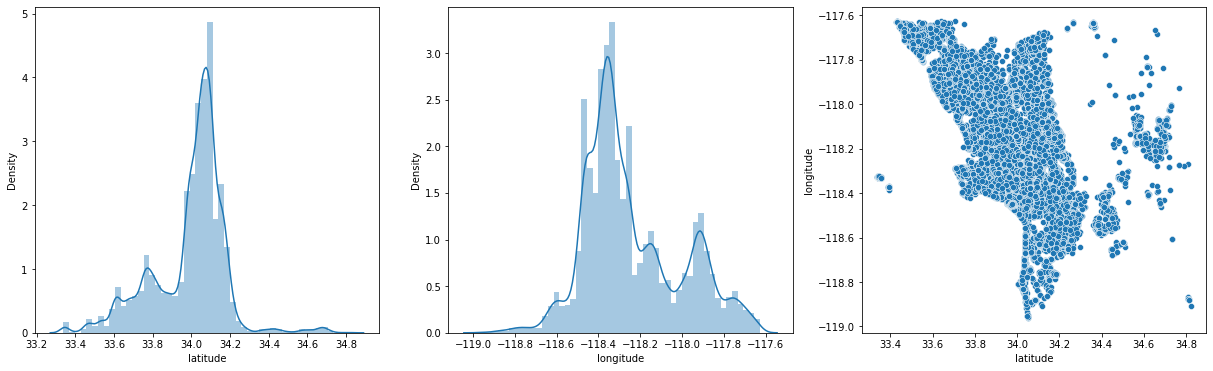

In [25]:
fig, axes = plt.subplots(1,3, figsize=(21,6))
sns.distplot(Combined_data['latitude'], ax=axes[0])
sns.distplot(Combined_data['longitude'], ax=axes[1])
sns.scatterplot(x= Combined_data['latitude'], y=Combined_data['longitude'])

Room type

From the bar plot below, we notice that categories of room types are highly imbalanced. The entire home/apt dominates the room types. The hotel room and share room take a very small portion of the house types.


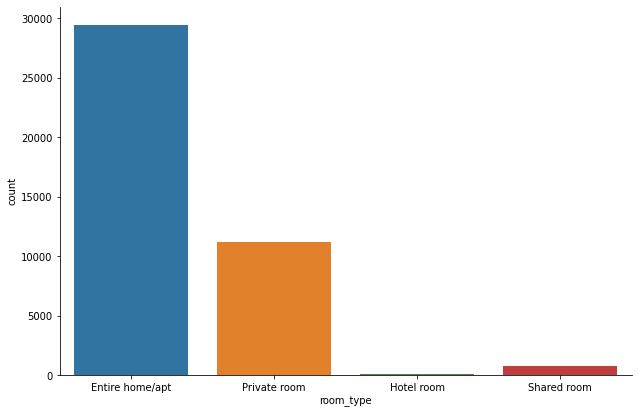

In [26]:
sns.catplot(x='room_type', kind='count' ,data=Combined_data)
fig = plt.gcf()
fig.set_size_inches(10, 6)

Minimum nights

Minimum nights is a little bit right skewed, so taking the log transformation can make it better distributed.

Text(0.5, 1.0, 'minimum nights distribution (after transformation)')

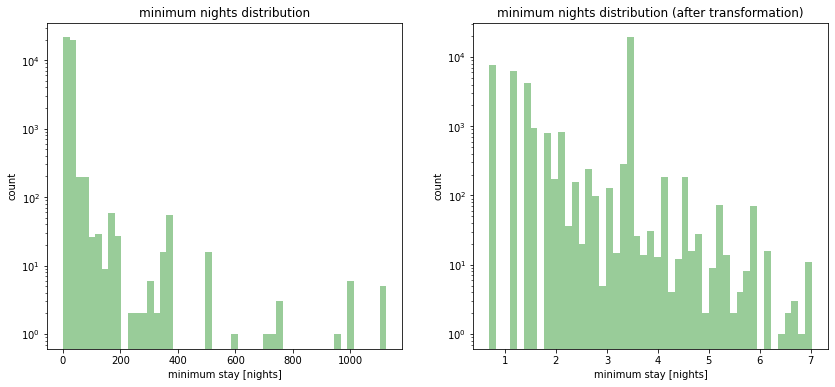

In [27]:
fig, axes = plt.subplots(1,2, figsize=(14, 6))

sns.distplot(Combined_data['minimum_nights'], rug=False, kde=False,
             color="green", ax = axes[0])
axes[0].set_yscale('log')
axes[0].set_xlabel('minimum stay [nights]')
axes[0].set_ylabel('count')
axes[0].set_title('minimum nights distribution')

sns.distplot(np.log1p(Combined_data['minimum_nights']), rug=False, kde=False, 
             color="green", ax = axes[1])
axes[1].set_yscale('log')
axes[1].set_xlabel('minimum stay [nights]')
axes[1].set_ylabel('count')
axes[1].set_title('minimum nights distribution (after transformation)')

In [28]:
Combined_data['minimum_nights'] = np.log1p(Combined_data['minimum_nights'])

Reviews per month

It contains outliers and highly right skewed. So we keep only the number < 17.5 and also take the root square. Taking root square can reduce right skewness and it works with zero values.

Text(0.5, 1.0, 'reviews_per_month distribution')

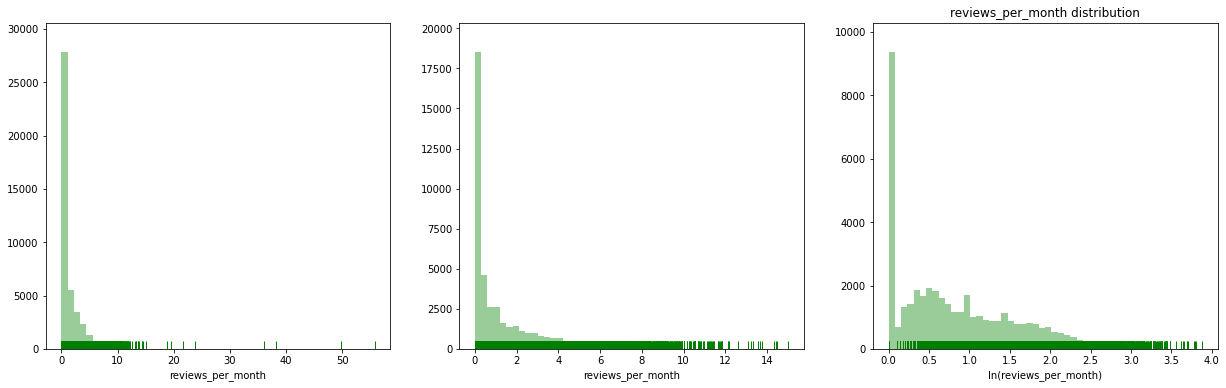

In [29]:
fig, axes = plt.subplots(1,3,figsize=(21, 6))
sns.distplot(Combined_data['reviews_per_month'], rug=True, kde=False, color="green", ax=axes[0])
sns.distplot(Combined_data[Combined_data['reviews_per_month'] < 17.5]['reviews_per_month'], rug=True, kde=False, color="green", ax=axes[1])
sns.distplot(np.sqrt(Combined_data[Combined_data['reviews_per_month'] < 17.5]['reviews_per_month']), rug=True, kde=False, color="green", ax=axes[2])
axes[2].set_xlabel('ln(reviews_per_month)')
plt.title('reviews_per_month distribution')

One explanation of few large number of reviews would be that the properties available a larger fraction of the year get more reviews. However, a scatter plot of reviews_per_month and availability_365 variables shows no evidence of a relationship so that explanation would appear to not be valid.

Text(0.5, 1.0, 'availability_365 vs reviews_per_month')

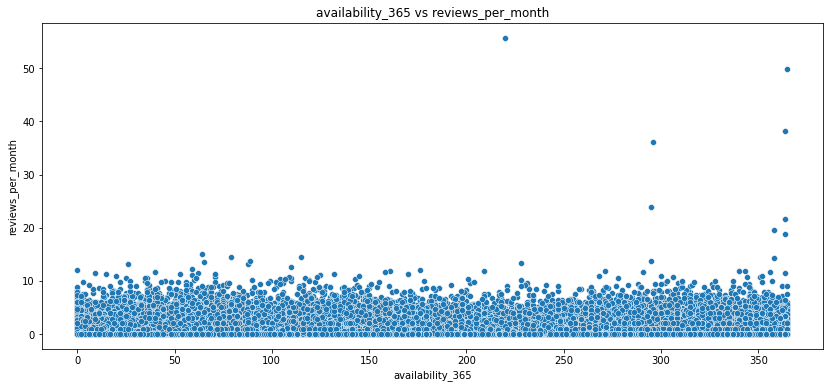

In [30]:
fig, axes = plt.subplots(1,1, figsize=(14,6))
sns.scatterplot(x= Combined_data['availability_365'], y=Combined_data['reviews_per_month'])
plt.title('availability_365 vs reviews_per_month')

In [31]:
Combined_data['reviews_per_month'] = Combined_data[Combined_data['reviews_per_month'] < 17.5]['reviews_per_month']

Availability_365

This distribution is highly skewed towards the low and high end. The dataset contains a huge number of properties that are available only for a couple of days each year. 

Text(0.5, 1.0, 'availability_365 Distribution')

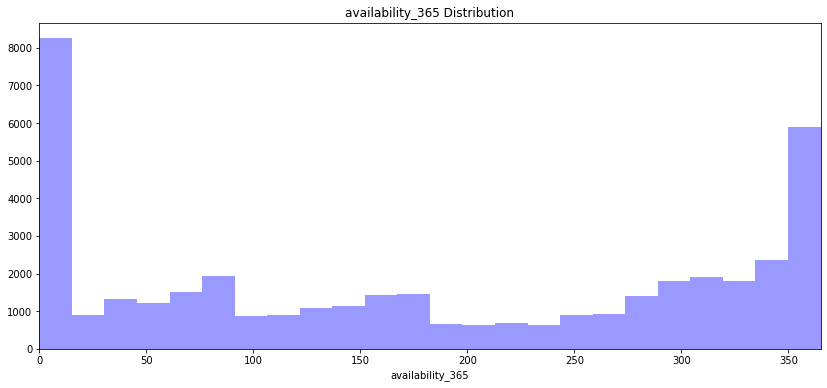

In [32]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))
sns.distplot(Combined_data['availability_365'], rug=False, kde=False, color="blue", ax=axes)
axes.set_xlabel('availability_365')
axes.set_xlim(0, 365)
plt.title('availability_365 Distribution')


Segment availability_365 into all_year_avail, low_avail, no_review, since this numerical variable is not likely to have linear relationship with the outcome.

In [33]:
Combined_data['all_year_avail'] = Combined_data['availability_365']>353
Combined_data['low_avail'] = Combined_data['availability_365']< 12
Combined_data['no_reviews'] = Combined_data['reviews_per_month']==0

Neighbourhood

Text(0.5, 1.0, 'Neighbourhood Distribution')

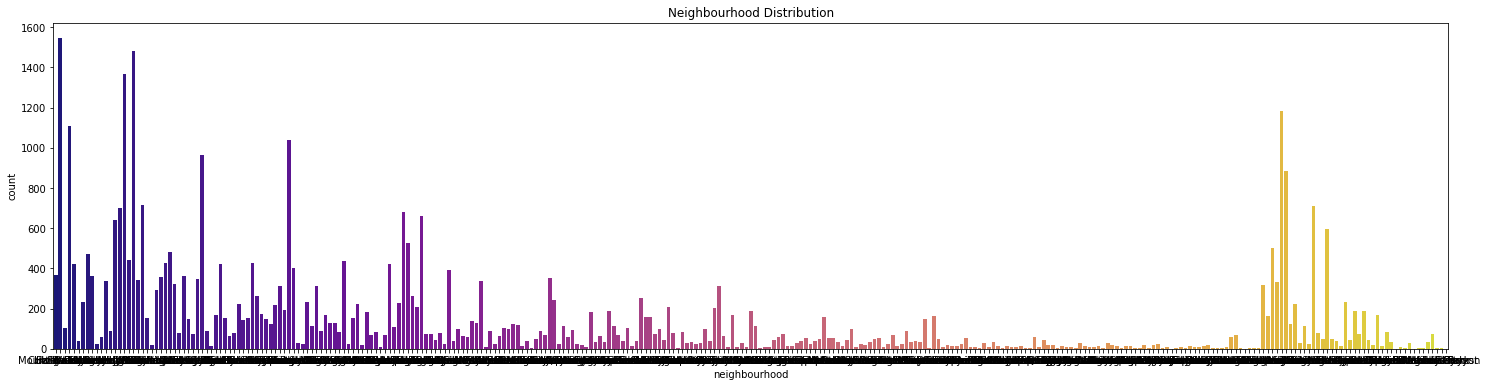

In [34]:
sns.countplot(Combined_data['neighbourhood'], palette="plasma")
fig = plt.gcf()
fig.set_size_inches(25,6)
plt.title('Neighbourhood Distribution')

In [35]:
Combined_data.neighbourhood.value_counts().head(20)

Hollywood               1545
Venice                  1479
Long Beach              1369
Newport Beach           1183
Santa Monica            1107
Downtown                1037
West Hollywood           966
Anaheim                  886
Glendale                 714
Irvine                   708
Hollywood Hills          700
Sherman Oaks             678
Inglewood                663
Beverly Hills            640
Santa Ana                597
Rowland Heights          524
Huntington Beach         500
Pasadena                 479
Hollywood Hills West     470
Mid-Wilshire             441
Name: neighbourhood, dtype: int64

## 2. Bivariate correlations

The figure below shows the relationship between neighbourhood_group and price. It seems neighbourhood_group has low discrimination power in predicting price.

Text(0.5, 1.0, 'Density and distribution of prices for each neighberhood_group')

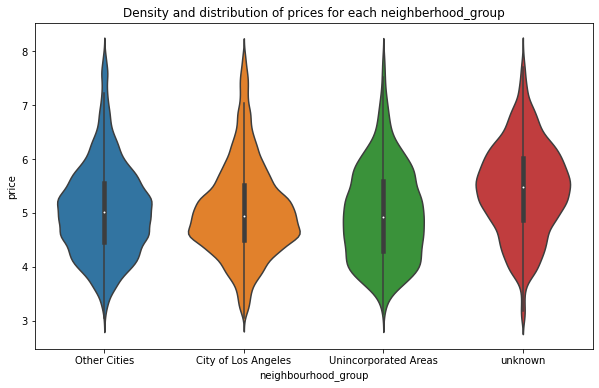

In [36]:
fig, axes = plt.subplots(1,1, figsize=(10,6))
viz_neigh_group=sns.violinplot(data=Combined_data[Combined_data.price < 500], x='neighbourhood_group', y='price')
viz_neigh_group.set_title('Density and distribution of prices for each neighberhood_group')

The figure below shows how frequency of neighbourhood varies by room types. The observation that is definitely contrasted the most is that 'Shared room' and 'Hotel room' type Airbnb listings are barely available among 10 most listing-populated neighborhoods.

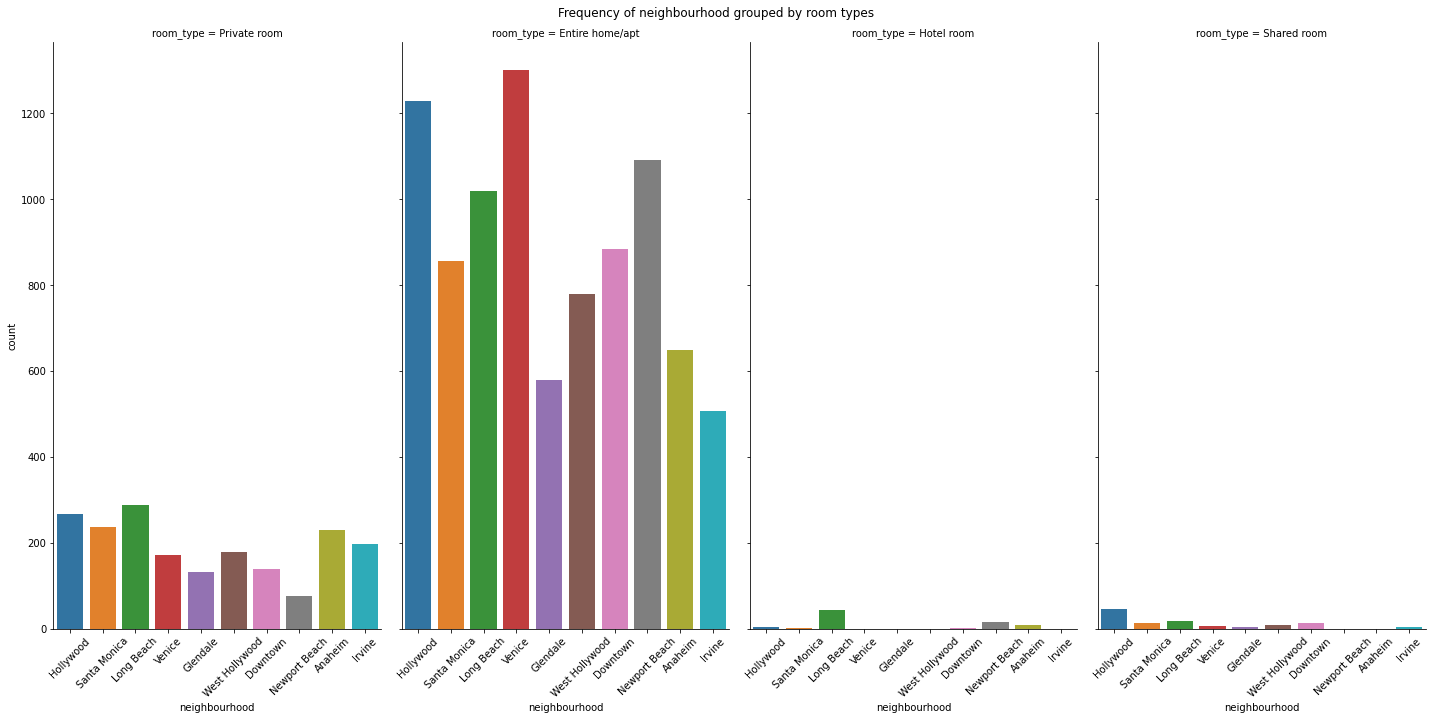

In [37]:
#grabbing top 10 neighbourhoods for sub-dataframe
top10 = ['Hollywood', 'Venice', 'Long Beach', 'Newport Beach', 'Santa Monica',
         'Downtown', 'West Hollywood', 'Anaheim', 'Glendale', 'Irvine']
sub_neighbourhood10=Combined_data.loc[Combined_data['neighbourhood'].isin(top10)]

# fig, axs = plt.subplots(1,1, figsize = (10,6))
g = sns.catplot(x='neighbourhood', col='room_type', #hue='neighbourhood_group', 
                      data=sub_neighbourhood10, kind='count')
g.set_xticklabels(rotation = 45)
g.fig.suptitle("Frequency of neighbourhood grouped by room types")
g.fig.set_size_inches(20,10)


The the following figure we can see how different the prices are in top 20 neighberhood. Houses close to Long Beach and Huntington Beach seem to have higher prices, while houses close to Beverly Hills have overall lower prices.

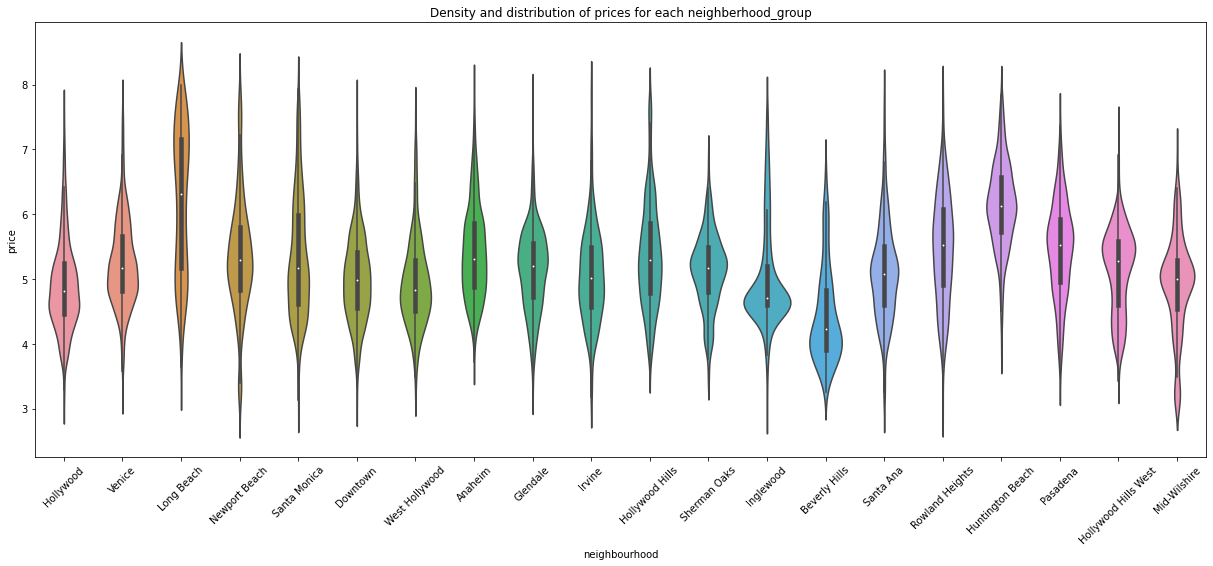

In [38]:
top20 = ['Hollywood', 'Venice', 'Long Beach', 'Newport Beach', 'Santa Monica',
         'Downtown', 'West Hollywood', 'Anaheim', 'Glendale', 'Irvine',
         'Hollywood Hills', 'Sherman Oaks', 'Inglewood', 'Beverly Hills',
         'Santa Ana', 'Rowland Heights', 'Huntington Beach', 'Pasadena', 
         'Hollywood Hills West','Mid-Wilshire']
sub_neighbourhood20=Combined_data.loc[Combined_data['neighbourhood'].isin(top20)]
viz_neigh2, axs = plt.subplots(1,1,figsize=(21,8))
viz_neigh2=sns.violinplot(data=sub_neighbourhood20[sub_neighbourhood20.price < 500], 
                          x='neighbourhood', y='price')
viz_neigh2.set_title('Density and distribution of prices for each neighberhood_group')
_ = viz_neigh2.set_xticklabels(top20, rotation = 45)

Text(0.5, 1.0, 'Density and distribution of prices for each neighberhood_group')

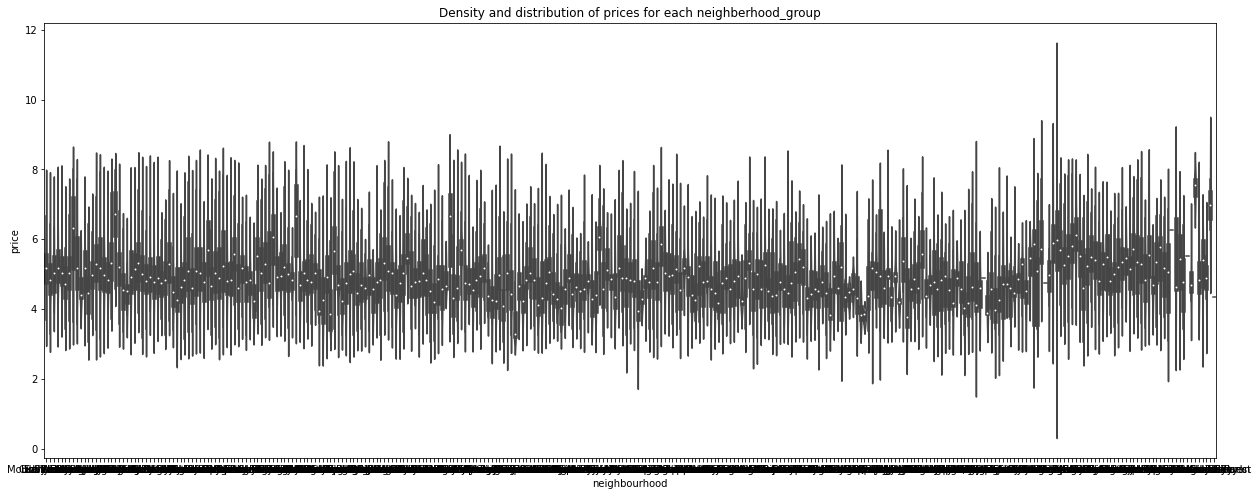

In [39]:
viz_neigh2, axs = plt.subplots(1,1,figsize=(21,8))
viz_neigh2=sns.violinplot(data=Combined_data[Combined_data.price < 500], 
                          x='neighbourhood', y='price')
viz_neigh2.set_title('Density and distribution of prices for each neighberhood_group')

We visualized prices of all listings in Los Angeles by using longitude and latitude. The color coded range indicates the price range. Price differnece can be easily seen after dropping extremely large values.

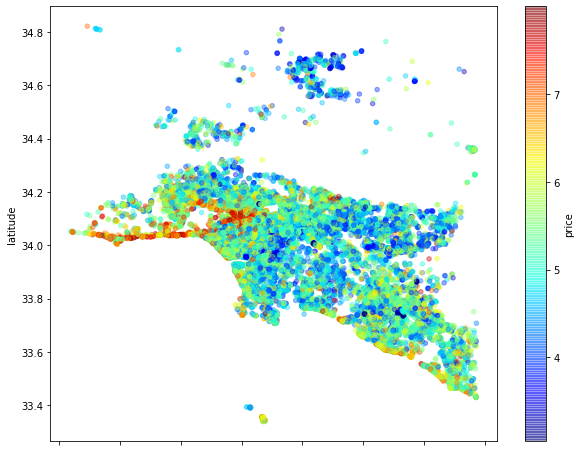

In [40]:
viz_loc=Combined_data[Combined_data['price'] < 500].plot(kind='scatter', x='longitude', y='latitude', #label='price', 
                                                         c='price', cmap=plt.get_cmap('jet'), 
                                                         colorbar=True, alpha=0.4, figsize=(10,8))
# viz_loc.legend()

Pearson correlation matrix

There are strong correlations between last_review and no_reviews. In addition, there are correlations between reviews_per_month and number_of_reviews, as well as between low_avail and availability_365.

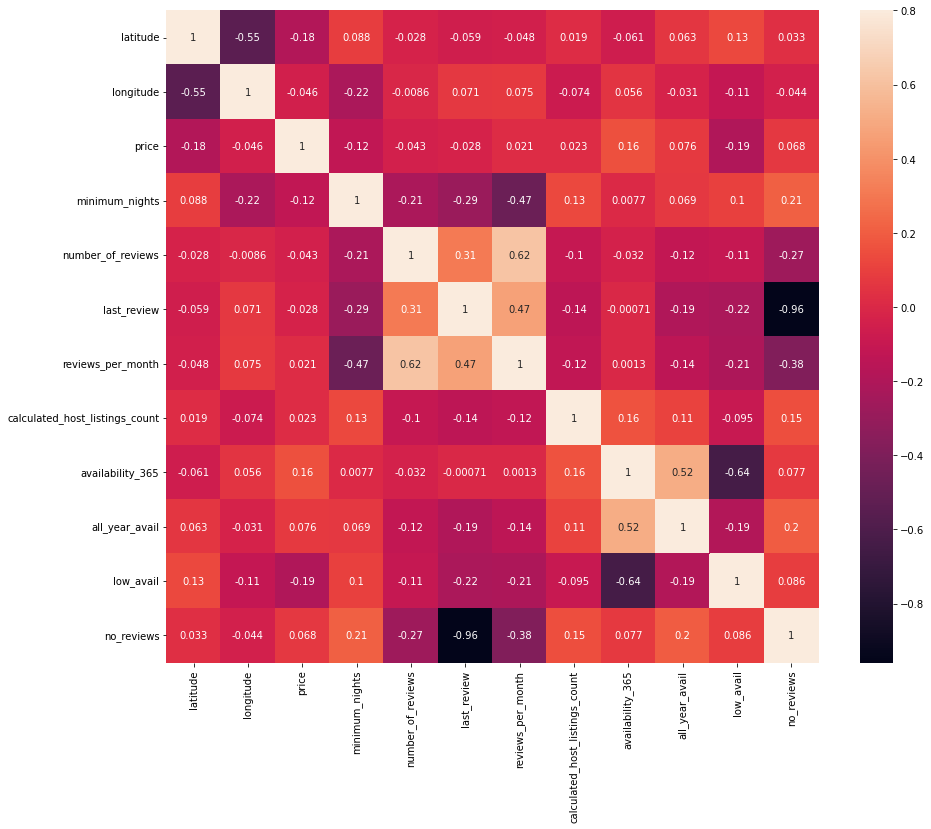

In [41]:
corrmatrix = Combined_data.corr()
f, ax = plt.subplots(figsize=(15,12))
sns.heatmap(corrmatrix, vmax=0.8, square=True, annot=True)
sns.set(font_scale=0.8)

We decide to drop last_review since it's highly correlated to no_reviews and also not practical for making predictions of future.

In [42]:
Combined_data.drop(['last_review'], axis = 1, inplace=True)

## 3. Encoding categorical features

In [43]:
categorical_features = Combined_data.select_dtypes(include=['object'])
print('Categorical features: {}'.format(categorical_features.shape))
categorical_features.columns

Categorical features: (41597, 3)


Index(['neighbourhood_group', 'neighbourhood', 'room_type'], dtype='object')

In [44]:
categorical_features_one_hot = pd.get_dummies(categorical_features)
categorical_features_one_hot.head()

,neighbourhood_group_City of Los Angeles,neighbourhood_group_Other Cities,neighbourhood_group_Unincorporated Areas,neighbourhood_group_unknown,neighbourhood_Acton,neighbourhood_Adams-Normandie,neighbourhood_Agoura Hills,neighbourhood_Agua Dulce,neighbourhood_Alhambra,neighbourhood_Aliso Viejo,...,neighbourhood_Willowbrook,neighbourhood_Wilmington,neighbourhood_Windsor Square,neighbourhood_Winnetka,neighbourhood_Woodland Hills,neighbourhood_Yorba Linda,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [45]:
Combined_data['reviews_per_month'] = Combined_data['reviews_per_month'].fillna(0)

Save transformed dataframe for future use

In [46]:
numerical_features =  Combined_data.select_dtypes(exclude=['object'])
y = numerical_features.price
numerical_features = numerical_features.drop(['price'], axis=1)
print('Numerical features: {}'.format(numerical_features.shape))

Numerical features: (41597, 10)


In [47]:
X = np.concatenate((numerical_features, categorical_features_one_hot), axis=1)
X_df = pd.concat([numerical_features, categorical_features_one_hot], axis=1)
print('Dimensions of the design matrix: {}'.format(X.shape))
print('Dimension of the target vector: {}'.format(y.shape))

Dimensions of the design matrix: (41597, 323)
Dimension of the target vector: (41597,)


In [48]:
# Processed_data = pd.concat([X_df, y], axis = 1)
# Processed_data.to_csv('Airbnb_LA_Processed.dat')